# analysis script: analyse_nodes
calculates correlation of integration and beauty for subsets of DNN nodes and maps this score back onto the nodes of these indivifidual subsets.

do this for hundrets/thousands of subsets.

In [1]:
import os
import numpy as np
import pandas as pd
import pickle

from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns

# modified visualpriors library
from transforms import VisualPriorRepresentation

from classes_analyse_nodes import (
    ImageDataset,
    Pattern_Generator,
    Activation_Pattern,
    NetworkScorer,
    calculate_integration_coeff,
    taskonomy_activation_layer_shapes,
    correlate_integration_beauty,
    )

import torch
import torch.utils.model_zoo # required to load nets
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

from scipy.stats import pearsonr, spearmanr

In [2]:
DATASET_NAMES = ('places1', 'places2', 'oasis')
SCALE_NAMES = ('scale2','scale4','scale8','scale16','scale32')

In [3]:
DATA_PATH = './data_256x256'
BEHAVIOR_PATH = './behavior'
RESULTS_PATH = './results_taskonomy'

In [4]:
#VisualPrior.viable_feature_tasks
MODEL_NAMES = ('autoencoding','depth_euclidean','jigsaw','reshading',
               'edge_occlusion','keypoints2d','room_layout', #'colorization' currently not working
               'curvature','edge_texture','keypoints3d','segment_unsup2d',
               'class_object','egomotion','nonfixated_pose','segment_unsup25d',
               'class_scene','fixated_pose','normal','segment_semantic',
               'denoising','inpainting','point_matching','vanishing_point')

In [5]:
IMAGE_TRANSFORMS = ('untransformed')

In [6]:
# storing a NetworkScorer object for saving backprojected scores
# TODO needs to be adapted when analysing multiple nets
BACKPROJECTED_SCORES_FOLDER = './backprojected_scores'

In [7]:
# TODO
# include back projection into analysis loop directly so individual subset calculations can be run independently
# and i can just let more subset calculations run whenevery i have time.

In [8]:
# run analysis
# map back score into network scorere
# save network scorer every 10 subsets
# save how many subset iterations were added in a seperate file
# optional: write script that allows saving on a button press and then saves latest progress

In [9]:
#setup net
model_name = MODEL_NAMES[9] #segment semantic
VisualPriorRepresentation._load_unloaded_nets([model_name])
net = VisualPriorRepresentation.feature_task_to_net[model_name]

In [10]:
#setup activation extractor
_, eval_nodes = get_graph_node_names(net)
return_nodes = { node:node for node in eval_nodes if "conv" in node or 'fc' in node}
activation_extractor = create_feature_extractor(net, return_nodes=return_nodes)

In [11]:
# get shape of activation
#dummy image
dataset = ImageDataset(os.path.join(DATA_PATH, DATASET_NAMES[0], SCALE_NAMES[0]))
dummy_image = next(iter(dataset))
net_activation = activation_extractor(dummy_image[0])
net_activation = OrderedDict(net_activation)
# get activation shape
activation_shapes = taskonomy_activation_layer_shapes(net_activation)

In [12]:
# load beauty ratings
beauty_ratings = ImageDataset(
    os.path.join(DATA_PATH, DATASET_NAMES[0], SCALE_NAMES[0]),
    beauty_ratings_path='behavior/ratings_study1.csv').beauty_ratings

In [13]:
num_layers = activation_shapes.__len__()
num_images = dataset.img_count

In [14]:
# when running for the first time (for this DNN)
ns = NetworkScorer(activation_shapes)

# integration-beauty

In [ ]:
subset_batch_size = 100

In [ ]:
# when running not for the first time (for this DNN)
# load existing scores from previously executet iterations
iterations = [int(filename[len("iteration_"):])
              for filename in os.listdir(BACKPROJECTED_SCORES_FOLDER)]

highest_iteration = max(iterations)

ns = NetworkScorer.load(os.path.join(BACKPROJECTED_SCORES_FOLDER, "iteration_" + str(highest_iteration)))

In [ ]:
while True:
    cnt = 0

    # new random subsets every time
    pat = Pattern_Generator(
        subset_batch_size,  
        activation_shapes,
        frac=0.01
        )

    # layer x image x subset
    integration = np.full([num_layers,num_images,subset_batch_size], np.nan)
    integration.shape


    # iterate image set
    for img_id, (img_full, img_v1, img_v2) in enumerate(iter(dataset)):
        if cnt % 100 == 0: print(cnt, end=' ')
        cnt=cnt+1
        
        act_full = Activation_Pattern(activation_extractor(img_full))
        act_v1   = Activation_Pattern(activation_extractor(img_v1))
        act_v2   = Activation_Pattern(activation_extractor(img_v2))
        act_avg  = Activation_Pattern.average(act_v1, act_v2)

        # iterate node subsets
        for subset_num in range(subset_batch_size):
            subset_mask = pat.get_subset_pattern(subset_num)
            
            subset_act_full = act_full[subset_mask]
            subset_act_avg  = act_avg[subset_mask]

            # calculate integration and store it
            subset_integration = calculate_integration_coeff(subset_act_full, subset_act_avg)
            integration[:,img_id, subset_num] = subset_integration
    
  
    # score (correlate) integration-beauty
    correlations = correlate_integration_beauty(integration, beauty_ratings)
    scores = np.abs(correlations)

    # map back scores onto nodes from this iteration of the dataset
    ns.map_back_scores(scores, pat)

    # save progress to disc at every iteration
    dir=os.path.join(BACKPROJECTED_SCORES_FOLDER, "iteration_" + str(ns.subset_iterations_count))
    os.mkdir(dir)
    # save
    ns.save(dir)
    print()

# individual images visual integration

In [14]:
subset_batch_size = 1000

# new random subsets every time
pat = Pattern_Generator(
    subset_batch_size,  
    activation_shapes,
    frac=0.01
    )

# layer x image x subset
integration = np.full([num_layers,num_images,subset_batch_size], np.nan)
integration.shape

(49, 250, 1000)

In [15]:
# iterate image set
for img_id, (img_full, img_v1, img_v2) in enumerate(iter(dataset)):    
    act_full = Activation_Pattern(activation_extractor(img_full))
    act_v1   = Activation_Pattern(activation_extractor(img_v1))
    act_v2   = Activation_Pattern(activation_extractor(img_v2))
    act_avg  = Activation_Pattern.average(act_v1, act_v2)

    # iterate node subsets
    for subset_num in range(subset_batch_size):
        subset_mask = pat.get_subset_pattern(subset_num)
        
        subset_act_full = act_full[subset_mask]
        subset_act_avg  = act_avg[subset_mask]

        # calculate integration and store it
        subset_integration = calculate_integration_coeff(subset_act_full, subset_act_avg)
        integration[:,img_id, subset_num] = subset_integration

In [18]:
with open('./individual_image_analysis/taskonomy9.npy', 'wb') as file:
    np.save(file, integration)

In [19]:
with open('./individual_image_analysis/taskonomy18.npy', 'rb') as file:
    btegration = np.load(file)

In [36]:
np.array(btegration.shape).cumprod()[-1]

12250000

In [20]:
(btegration == integration).sum()

0

In [22]:
btegration.shape

(49, 250, 1000)

In [24]:
pat.num_subsets

1000

In [32]:
# map back scores for one image
img_idx = 0
image_scores = btegration[:,img_idx, :]

ns_img = NetworkScorer(activation_shapes)
ns_img.map_back_scores(image_scores, pat)

In [56]:
layernames = list(ns_img.scores.keys())
ns_img.scores[layernames[35]].flatten()

tensor([ -7.2637,  -6.5449,  -2.1384,  ...,  -9.4562, -10.1258,  -9.4717])

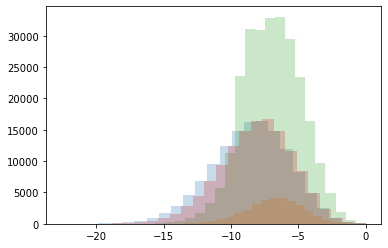

In [55]:
for i in [10, 20, 30, 40]:
    plt.hist(ns_img.scores[list(ns_img.scores.keys())[i]].flatten(), bins=25, alpha = .25)